In [67]:
import pandas as pd
import altair as alt
alt.renderers.set_embed_options(theme='dark')
pd.set_option('display.max_colwidth', None)

# Analysis & Charts

In [68]:
def claim(claim_hash):
    try:
        df_claim = pd.read_json(
            f'https://node-api.flipsidecrypto.com/api/v2/queries/{claim_hash}/data/latest',
            convert_dates=["BLOCK_TIMESTAMP"],
        )
    except Exception as e:
        print(e)
        return 
    return df_claim

In [69]:
class DataProvider:    
    
    def __init__(self):
        self.vote = 'a3efd3f0-724b-4a26-9f92-6083c7c52785'
        self.date_wallet = '074c2ad1-a842-442d-a0f5-6456b35be648'
    
    def get_vote(self):
        df = claim(self.vote)
        df.columns = [c.lower() for c in df.columns]
        return df
    
    def get_date_wallet(self):
        df = claim(self.date_wallet)
        df.columns = [c.lower() for c in df.columns]
        return df
    
   

In [70]:
dp = DataProvider()

In [71]:
df = dp.get_vote()[['date', 'address', 
       'block_timestamp', 'tx_id',
       'proposal_id', 'option', 'voting_power',  'balance','currency']]
df.head()

,date,address,block_timestamp,tx_id,proposal_id,option,voting_power,balance,currency
0,2022-05-18,terra10ef4efde03ege270dss7gr697c9vnn78dlu0y3,2022-05-18 12:45:21.462,DD9658FDAAC260E62C1FE6C76AD4D340051E1B011FAFFC423EDD8EF0CFC4EACE,1623,VOTE_OPTION_NO_WITH_VETO,NaN,6.3,LUNA
1,2022-05-18,terra15lwqplpy9m45cyt6e5740tjn7fvf9rggqs3lxm,2022-05-18 13:43:46.525,BB54192D87483E92C894B5E74B6C5085773943D78AB589940EFC6A68BB92B36F,1623,VOTE_OPTION_YES,NaN,0.0,LUNA
2,2022-05-18,terra1472skx209kxen6xcp8lmghpyjkdsea23nh7386,2022-05-18 13:07:56.294,020DECDE415378C0067A7721DF28AB728C279186E51A3027C9D9A2E67B554D47,1623,VOTE_OPTION_YES,NaN,0.0,LUNA
3,2022-05-18,terra184620h8m0z75ts2a3wrhj3rfsct5waww507lvl,2022-05-18 17:02:13.630,8318DF81A6D78572DC3A8948F700BC9C8B99516302377294EDB84AE36433EFD7,1623,VOTE_OPTION_NO_WITH_VETO,NaN,0.0,LUNA
4,2022-05-18,terra1t5tcvnxsjfx5ecz6lclwdcfdw3c2v3t85dwlk7,2022-05-18 13:10:19.719,AAAB7A14A8CCACF32E8DC839AD09AB9D82B65A3597118AA8772A8E1F81DE8E7A,1623,VOTE_OPTION_YES,NaN,0.0,LUNA


In [72]:
df.set_index('tx_id').to_json('../data/votes_tx.json')

In [73]:
df.option.unique()

array(['VOTE_OPTION_NO_WITH_VETO', 'VOTE_OPTION_YES', 'VOTE_OPTION_NO',
       'VOTE_OPTION_ABSTAIN'], dtype=object)

In [74]:
df['hours_since_start'] = (df.block_timestamp - df.block_timestamp.min()).apply(lambda x: x.total_seconds() / 3600)

In [75]:
df.option = df.option.map({'VOTE_OPTION_NO_WITH_VETO':'No with veto',
               'VOTE_OPTION_YES':'Yes',
               'VOTE_OPTION_NO':'No',
               'VOTE_OPTION_ABSTAIN':'Abstain'})

In [76]:
df.to_json('../data/votes.json',orient='records')

In [112]:
wc = dp.get_date_wallet()
wc['date'] = wc['min(date)']
wc['age'] = (pd.Timestamp('2022-05-20') - pd.to_datetime(wc.date)).apply(lambda x: x.total_seconds()/3600/24)

In [78]:
def typew(date):
    if(date<'2021-09-30'):
        return 'Pre-Col5'
    if((date>='2021-09-30')&(date<='2022-05-07')):
        return 'Post-Col5'
    if((date>'2021-05-07')):
        return 'Post-DePeg'

wc['typew'] = wc.date.apply(typew)

In [115]:
df.merge(wc[['address','age']], on='address', how='left').to_json('../data/votes.json',orient='records')

In [79]:
m = wc.merge(df, on='address')

<AxesSubplot:title={'center':'Number of Users'}>

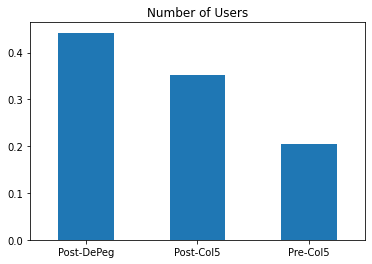

In [116]:
m.typew.value_counts(normalize=True).plot(kind='bar',rot=0, title='Number of Users')

<AxesSubplot:title={'center':'Voting Power'}, xlabel='typew'>

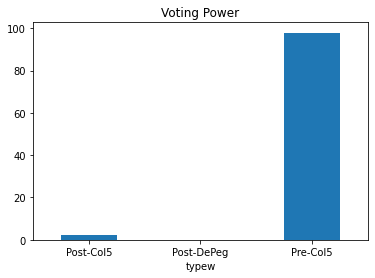

In [117]:
dfm = (m.groupby('typew').balance.sum())/1000000
(dfm/dfm.sum()*100).plot(kind='bar', rot=0, title='Voting Power')

<AxesSubplot:title={'center':'Post-DePeg'}>

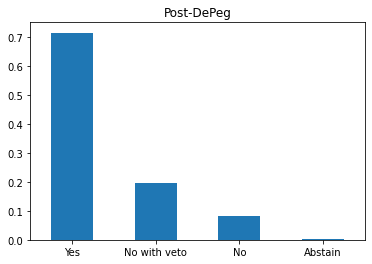

In [121]:
t='Post-DePeg'
m[m.typew==t].option.value_counts(normalize=True).plot(kind='bar', rot=0, title=t)

In [100]:
m[m.typew=='Post-DePeg'].option.value_counts(normalize=True)

Yes             0.716236
No with veto    0.196600
No              0.083333
Abstain         0.003831
Name: option, dtype: float64

In [93]:
m[m.typew=='Post-Col5'].option.value_counts(normalize=True)

Yes             0.619205
No with veto    0.237207
No              0.136665
Abstain         0.006924
Name: option, dtype: float64

In [94]:
m[m.typew=='Pre-Col5'].option.value_counts(normalize=True)

Yes             0.734778
No with veto    0.161507
No              0.091847
Abstain         0.011868
Name: option, dtype: float64